# Find best parameters describing data, both combined and separated fits. 


In [35]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline 
from scipy.optimize import curve_fit
import pickle
import sys
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib as mpl
import scipy.stats as stats
import pandas as pd
from importlib import reload
from scipy.interpolate import interp1d,interp2d

import os
cwd=os.getcwd()

area=4.0;linethicknes=1.0;

font = {'family' : 'normal','weight' : 'normal','size'   : 7, 'family':'serif','serif':['Arial']}
mpl.rc('font', **font)
mpl.rcParams['lines.linewidth'] =linethicknes
mpl.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rcParams['pdf.fonttype'] = 42
area=4.0;linethicknes=1.0;


########################################################################
############# Import code

sys.path.insert(0, './../../../DataAndScripts/unstructured_scripts/')
import functions_optimal as fun
import sims_utils as su
import functions_dynamics as fun_dyna

# Load results file
This file is the outcome of hundreds of thousands of simulations run in the cluster

In [2]:

path2results=cwd+'/../../../DataAndScripts/unstructured_scripts/simulation_results/'
results, jn = su.get_concatenated_results(path2results)

    

Your results files are of the form: results
Found 5 results files
Last loaded file number: 4


In [3]:
sim_param_all=results[:,0:15]
moments_of_r_sim_all=results[:,15:20]

sim_g_E=(sim_param_all[:,2])
sim_g_I=(sim_param_all[:,3])
sim_beta=(sim_param_all[:,4])
sim_CV_K=(sim_param_all[:,7])
sim_sigma_Lambda_over_Lambda=(sim_param_all[:,10])
sim_J=(sim_param_all[:,11])
sim_r_X=(sim_param_all[:,12])
sim_ell=(sim_param_all[:,13])

print(np.shape(results))
#(121278, 28)


param_min=np.asarray([np.min(sim_g_E),np.min(sim_g_I),np.min(np.log10(sim_beta)),
                      np.min(np.log10(sim_CV_K)),np.min(np.log10(sim_sigma_Lambda_over_Lambda)),np.min(np.log10(sim_J)),])
param_max=np.asarray([np.max(sim_g_E),np.max(sim_g_I),np.max(np.log10(sim_beta)),
                      np.max(np.log10(sim_CV_K)),np.max(np.log10(sim_sigma_Lambda_over_Lambda)),np.max(np.log10(sim_J)),])
    


(770195, 28)


# Load recordings in mice and monkeys

In [4]:

#######################################
folder_data='./../../../DataAndScripts/experimental_data/'
#######################################

data_monkeys=np.loadtxt(folder_data+'Monkeys_with_trials.txt');
data_mice=np.loadtxt(folder_data+'Mice_with_trials.txt');

data_both_species=[data_mice,data_monkeys]
species=['Mice','Monkeys']

dataset_both_species,Con_both_species,nCon_both_species,normalization_both_species=[],[],[],[]
for idx_species in range(2):
    dataset,Con,nCon=fun.build_dataset(data_both_species[idx_species])
    normalization=1.0;#np.mean(dataset[0,:,0])
    dataset_both_species=dataset_both_species+[dataset]
    Con_both_species=Con_both_species+[Con]
    nCon_both_species=nCon_both_species+[nCon]
    normalization_both_species=normalization_both_species+[normalization]


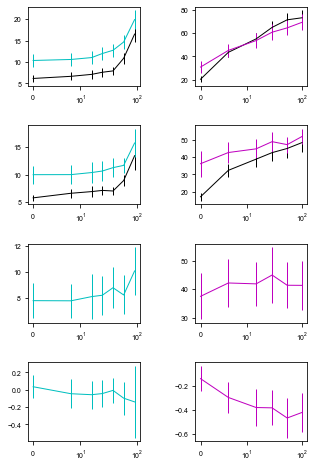

In [5]:

rows=4
cols=2

colors=['c','m']
fig, axs = plt.subplots(rows,cols, figsize=(2.5*cols,2.*rows), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)
axs = axs.ravel()



for idx_species in range(2):
    dataset=dataset_both_species[idx_species]
    Con=Con_both_species[idx_species]
    nCon=nCon_both_species[idx_species]

    for idx_moment in range(6):
        if idx_moment<2:
            idx_row=0
            ccc=['k',colors[idx_species]][idx_moment]
            
        if (idx_moment>=2)&(idx_moment<4):
            idx_row=1
            ccc=['k',colors[idx_species]][idx_moment-2]

        if (idx_moment==4):
            idx_row=2
            ccc=colors[idx_species]

        if (idx_moment==5):
            idx_row=3
            ccc=colors[idx_species]
            
        axs[2*idx_row+idx_species].errorbar(Con,dataset[idx_moment,:,0],dataset[idx_moment,:,1],
                                                 color=ccc,)

        axs[2*idx_row+idx_species].set_xscale('symlog', linthreshx=12)




# Obtain predicted activity from the MLP fitted in the previous notebook

The fun.build_function, loads the files created in design_fits (which are MLP fitted to many simulation results, creating a mapping from simulation paramter to network statistics), and creates functions that, given a parameter set,gives us statistics of network response 

In [25]:
with open('./../../../DataAndScripts/unstructured_scripts//model_files/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

In [11]:
cwd=os.getcwd()
Predictor_sim, Predictor_data=fun.build_function('./../../../DataAndScripts/unstructured_scripts/')

# Fit a model to each species separately


In this part, we fit the model multiple times, with different initial conditions, compute the error and store it, then we have an ensamble of fits and choose the best


In [19]:
reload(fun)

nRep=10;
ALL_sol,ALL_cost=[],[]
for idx_species in range(2):
    print('Doing '+ species[idx_species])
    dataset=dataset_both_species[idx_species]
    Con=Con_both_species[idx_species]
    nCon=nCon_both_species[idx_species]
    sol,cost=fun.fit_model_to_data(dataset,Predictor_data,nCon,nRep,param_min=None,param_max=None)
    
    ALL_sol=ALL_sol+[sol]
    ALL_cost=ALL_cost+[cost]


  0%|          | 0/10 [00:00<?, ?it/s]

Doing Species Mice


  0%|          | 0/10 [00:00<?, ?it/s]

Doing Species Monkeys


100%|██████████| 10/10 [00:57<00:00,  5.75s/it]


# Save the best fit prediction of this separate fits to load it in the next notebook

In [36]:

#########################################################################################################
# We save this parameters to simulate the network in the next notebook
#########################################################################################################

best_separately={}


for idx_species in range(2):
    dataset=dataset_both_species[idx_species]
    Con=Con_both_species[idx_species]
    nCon=nCon_both_species[idx_species]
    
    sol=ALL_sol[idx_species]
    cost=ALL_cost[idx_species]
    idx_best=np.argmin(cost)
    best_param=sol[idx_best,:]
    best_cost=cost[idx_best]
    best_inputs=fun.fit_inputs_to_data_given_param(dataset,Predictor_data,best_param,nCon)
    

    best_separately['best_input_'+species[idx_species]]=best_inputs
    best_separately['best_params_'+species[idx_species]]=best_param

with open('./best_fit/Model_Fit_Separately_UntructModel-Best.pkl', 'wb') as handle_PR:
    pickle.dump(best_separately, handle_PR, protocol=pickle.HIGHEST_PROTOCOL)



# Plot the best fit prediction 

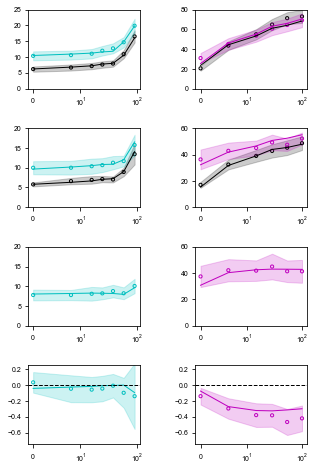

In [38]:

rows=4
cols=2

colors=['c','m']
fig, axs = plt.subplots(rows,cols, figsize=(2.5*cols,2.*rows), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)
axs = axs.ravel()



for idx_species in range(2):
    dataset=dataset_both_species[idx_species]
    Con=Con_both_species[idx_species]
    nCon=nCon_both_species[idx_species]
    
    best_inputs= best_separately['best_input_'+species[idx_species]]
    best_param = best_separately['best_params_'+species[idx_species]]
    
    
    Predictions=Predictor_data(best_inputs,best_param,nCon)
      
    for idx_moment in range(6):
        if idx_moment<2:
            idx_row=0
            ccc=['k',colors[idx_species]][idx_moment]
            ymin=0
            ymax=[25,80][idx_species]
            
        if (idx_moment>=2)&(idx_moment<4):
            idx_row=1
            ccc=['k',colors[idx_species]][idx_moment-2]
            ymin=0
            ymax=[20,60][idx_species]
         
        if (idx_moment==4):
            idx_row=2
            ccc=colors[idx_species]
            ymin=0
            ymax=[20,60][idx_species]
         
        if (idx_moment==5):
            idx_row=3
            ccc=colors[idx_species]
            ymin=-0.75
            ymax=0.25
                     
        m,sem=dataset[idx_moment,:,0],dataset[idx_moment,:,1]
        axs[2*idx_row+idx_species].scatter(Con,m,
                                           facecolors='none', s=10,edgecolors=ccc,marker='o'
                                           )
        axs[2*idx_row+idx_species].fill_between(Con,m-sem,m+sem,
                                                 color=ccc,alpha=0.2)
    
        axs[2*idx_row+idx_species].plot(Con,Predictions[idx_moment,:],
                                        color=ccc,alpha=1.)

        axs[2*idx_row+idx_species].set_xscale('symlog', linthreshx=12)
        axs[2*idx_row+idx_species].set_ylim([ymin,ymax])
        
        
        
        
        
        
        
        
        
    axs[2*idx_row+idx_species].axhline(y=0,ls='--',c='k')

# Now we fit the same model to both species. 
 In this case the input will then be the combined data for both species

In [23]:
reload(fun)
nRep=20;

DATA_both_species=[dataset_both_species,Con_both_species,nCon_both_species,normalization_both_species]
CMB_sol,CMB_cost=fun.fit_model_to_data_both_species(DATA_both_species,Predictor_data,nCon,nRep,None,None)


100%|██████████| 20/20 [06:26<00:00, 19.32s/it]


# Save the best fit prediction of this together fits to load it in the next notebook

In [39]:

#########################################################################################################
# We save this parameters to simulate the network in the next notebook
#########################################################################################################

best_together={}


for idx_species in range(2):
    dataset=dataset_both_species[idx_species]
    Con=Con_both_species[idx_species]
    nCon=nCon_both_species[idx_species]
    
    
    idx_best=np.argsort(CMB_cost)[0]
    best_param=CMB_sol[idx_best,:]
    best_cost=CMB_cost[idx_best]
    best_inputs=fun.fit_inputs_to_data_given_param(dataset,Predictor_data,best_param,nCon)

    best_together['best_input_'+species[idx_species]]=best_inputs
    best_together['best_params_'+species[idx_species]]=best_param

with open('./best_fit/Model_Fit_Together_UntructModel-Best.pkl', 'wb') as handle_PR:
    pickle.dump(best_together, handle_PR, protocol=pickle.HIGHEST_PROTOCOL)



# Plot the best fit prediction in this case

Mice 23.348806204844585
array([ 4.19,  2.92, -0.87, -1.78,  0.28, -3.89])
array([1.12, 1.16, 1.17, 1.18, 1.19, 1.26, 1.38, 0.22])
Monkeys 23.348806204844585
array([ 4.19,  2.92, -0.87, -1.78,  0.28, -3.89])
array([1.48, 1.72, 1.79, 1.86, 1.88, 1.9 , 0.67])


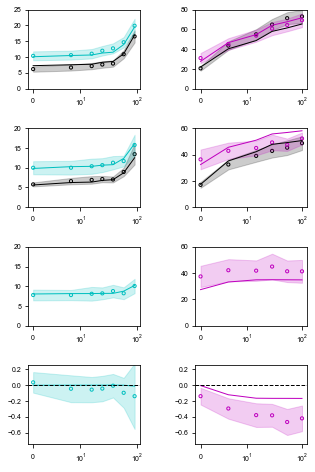

In [40]:

rows=4
cols=2

colors=['c','m']
fig, axs = plt.subplots(rows,cols, figsize=(2.5*cols,2.*rows), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)
axs = axs.ravel()



for idx_species in range(2):
    dataset=dataset_both_species[idx_species]
    Con=Con_both_species[idx_species]
    nCon=nCon_both_species[idx_species]
    normalization=normalization_both_species[idx_species] 

    best_inputs= best_together['best_input_'+species[idx_species]]
    best_param = best_together['best_params_'+species[idx_species]]
    
    
    Predictions=Predictor_data(best_inputs,best_param,nCon)
    print(['Mice','Monkeys'][idx_species],best_cost)
    print(repr(best_param))
    print(repr(best_inputs))        
    for idx_moment in range(6):
        if idx_moment<2:
            idx_row=0
            ccc=['k',colors[idx_species]][idx_moment]
            ymin=0
            ymax=[25,80][idx_species]
            
        if (idx_moment>=2)&(idx_moment<4):
            idx_row=1
            ccc=['k',colors[idx_species]][idx_moment-2]
            ymin=0
            ymax=[20,60][idx_species]
         
        if (idx_moment==4):
            idx_row=2
            ccc=colors[idx_species]
            ymin=0
            ymax=[20,60][idx_species]
         
        if (idx_moment==5):
            idx_row=3
            ccc=colors[idx_species]
            ymin=-0.75
            ymax=0.25
                     
        m,sem=dataset[idx_moment,:,0],dataset[idx_moment,:,1]
        axs[2*idx_row+idx_species].scatter(Con,m,
                                           facecolors='none', s=10,edgecolors=ccc,marker='o'
                                           )
        axs[2*idx_row+idx_species].fill_between(Con,m-sem,m+sem,
                                                 color=ccc,alpha=0.2)
    
        axs[2*idx_row+idx_species].plot(Con,Predictions[idx_moment,:],
                                        color=ccc,alpha=1.)

        axs[2*idx_row+idx_species].set_xscale('symlog', linthreshx=12)
        axs[2*idx_row+idx_species].set_ylim([ymin,ymax])
    axs[2*idx_row+idx_species].axhline(y=0,ls='--',c='k')

# Add fits to each species separately to a the file containing all the possible fits  

In [28]:
Tmax_over_tau_E=2*10**2
n_rep=20;
sigma_t=0.01; 
tau_rp=0.002; 


In [34]:
count=0;
for idx_rep in range(n_rep):
    for idx_combined in range(2):
        for idx_species in range(2):
            dataset=dataset_both_species[idx_species]
            Con=Con_both_species[idx_species]
            nCon=nCon_both_species[idx_species]
            normalization=normalization_both_species[idx_species] 
            if idx_combined==0:
                # best fit combined
                sol=ALL_sol[idx_species]
                cost=ALL_cost[idx_species]
                idx_best=np.argmin(cost)
                best_param=sol[idx_best,:]
            if idx_combined==1:
                # best fit in mice or monkeys
                idx_best=np.argmin(CMB_cost)
                best_param=CMB_sol[idx_best,:]
                best_cost=CMB_cost[idx_best]


            best_inputs=fun.fit_inputs_to_data_given_param(dataset,Predictor_data,best_param,nCon)

            Possible_r_X=10**best_inputs[0:-1]
            ell=10**best_inputs[-1]

            g_E= best_param[0]; g_I=best_param[1];beta=10**best_param[2]; 
            K=500; 
            CV_K=10**best_param[3]
            sigma_Lambda_over_Lambda=10**best_param[4];
            J=10**best_param[5];
            for idx_r_X in range(len(Possible_r_X)):
                r_X=Possible_r_X[idx_r_X];

                data=np.ones((1,14));
                data[:,0]=J
                data[:,1]=r_X
                data[:,2]=sigma_Lambda_over_Lambda
                data[:,3]=Tmax_over_tau_E
                data[:,4]=sigma_t
                data[:,5]=tau_rp
                data[:,6]=g_E 
                data[:,7]=g_I
                data[:,8]=beta
                data[:,9]=K
                data[:,10]=ell
                data[:,11]=CV_K
                data[:,12]=idx_species
                data[:,13]=idx_combined

                if count==0:
                    DATA=data;
                if count>0:
                    DATA=np.vstack((DATA,data));
                count=count+1

len(DATA)


#########################################################################################################
# We save this in our list of good parameters to build a family of good parameters
#########################################################################################################
df = pd.DataFrame(DATA,columns=['J','r_X','sigma_Lambda_over_Lambda','Tmax_over_tau_E','sigma_t','tau_rp',
                                'g_E','g_I','beta','K','ell','CV_K','idx_species','idx_combined'])
file_name='simulation_param.txt'
df.to_csv(file_name, sep='\t')


# Add fits to both species together to a the file containing all the possible fits  

In [32]:
count=0;
for idx_rep in range(n_rep):
    for idx_combined in range(10):
        for idx_species in range(2):
            dataset=dataset_both_species[idx_species]
            Con=Con_both_species[idx_species]
            nCon=nCon_both_species[idx_species]
            normalization=normalization_both_species[idx_species] 

            idx_best=np.argsort(CMB_cost)[idx_combined]
            best_param=CMB_sol[idx_best,:]
            best_cost=CMB_cost[idx_best]
           
        
            best_inputs=fun.fit_inputs_to_data_given_param(dataset,Predictor_data,best_param,nCon)


            Possible_r_X=10**best_inputs[0:-1]
            ell=10**best_inputs[-1]

            g_E= best_param[0]; g_I=best_param[1];beta=10**best_param[2]; 
            K=500; 
            CV_K=10**best_param[3]
            sigma_Lambda_over_Lambda=10**best_param[4];
            J=10**best_param[5];
            for idx_r_X in range(len(Possible_r_X)):
                r_X=Possible_r_X[idx_r_X];

                data=np.ones((1,14));
                data[:,0]=J
                data[:,1]=r_X
                data[:,2]=sigma_Lambda_over_Lambda
                data[:,3]=Tmax_over_tau_E
                data[:,4]=sigma_t
                data[:,5]=tau_rp
                data[:,6]=g_E 
                data[:,7]=g_I
                data[:,8]=beta
                data[:,9]=K
                data[:,10]=ell
                data[:,11]=CV_K
                data[:,12]=idx_species
                data[:,13]=idx_combined

                if count==0:
                    DATA=data;
                if count>0:
                    DATA=np.vstack((DATA,data));
                count=count+1

#########################################################################################################
# We save this in our list of good parameters to build a family of good parameters
#########################################################################################################

df = pd.DataFrame(DATA,columns=['J','r_X','sigma_Lambda_over_Lambda','Tmax_over_tau_E','sigma_t','tau_rp',
                                'g_E','g_I','beta','K','ell','CV_K','idx_species','idx_combined'])
file_name='simulation_param.txt'
df.to_csv(file_name, sep='\t')
